In [1]:
# Import modules
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
from utils import Search

In [2]:
# Create a client
cg = CoinGeckoAPI()

# Confirm connection
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

In [3]:
# Display all get methods
Search('get', dir(cg))

['__getattribute__',
 '__getstate__',
 'get_asset_platform_by_id',
 'get_asset_platforms',
 'get_coin_by_id',
 'get_coin_circulating_supply_chart',
 'get_coin_circulating_supply_chart_range',
 'get_coin_history_by_id',
 'get_coin_info_from_contract_address_by_id',
 'get_coin_market_chart_by_id',
 'get_coin_market_chart_from_contract_address_by_id',
 'get_coin_market_chart_range_by_id',
 'get_coin_market_chart_range_from_contract_address_by_id',
 'get_coin_ohlc_by_id',
 'get_coin_ohlc_by_id_range',
 'get_coin_ticker_by_id',
 'get_coin_top_gainers_losers',
 'get_coin_total_supply_chart',
 'get_coin_total_supply_chart_range',
 'get_coins',
 'get_coins_categories',
 'get_coins_categories_list',
 'get_coins_list',
 'get_coins_list_new',
 'get_coins_markets',
 'get_companies_public_treasury_by_coin_id',
 'get_derivatives',
 'get_derivatives_exchanges',
 'get_derivatives_exchanges_by_id',
 'get_derivatives_exchanges_list',
 'get_exchange_rates',
 'get_exchanges_by_id',
 'get_exchanges_id_name

In [4]:
# Retrieve the list of all coins from CoinGecko API.
coin_list = cg.get_coins_list()

# Convert the list of coins to a DataFrame, sort by 'id', and reset the index.
coin_list_df = pd.DataFrame(coin_list).sort_values(by='id').reset_index(drop=True)

# Display the resulting DataFrame containing all coins.
coin_list_df

,id,symbol,name
0,-10,loong,龙
1,-3,meow,Meow Meow Coin
2,-5,🟥🟩,🟥🟪🟦🟩🟨🟧
3,-6,""" """,""" """
4,-7,∅,∅
...,...,...,...
18258,zyfi,zfi,ZyfAI
18259,zygo-the-frog,zygo,Zygo The Frog
18260,zyncoin-2,zyn,ZynCoin
18261,zynecoin,zyn,Zynecoin


In [9]:
'''
args:
id (required)
vs_currency (required)
days (required)
interval
precision

Personal Notes:
- Method works best when all parameters are specified.

'''
btc_raw = cg.get_coin_market_chart_by_id(id = 'bitcoin', 
                                        vs_currency = 'usd', 
                                        days = 360, 
                                        interval = 'daily')

btc_raw

{'prices': [[1724803200000, 59526.560879590994],
  [1724889600000, 59015.29633887944],
  [1724976000000, 59351.5794909728],
  [1725062400000, 59156.246036463555],
  [1725148800000, 58960.23658664587],
  [1725235200000, 57357.71617282246],
  [1725321600000, 59108.73235863689],
  [1725408000000, 57504.538586220435],
  [1725494400000, 57987.84601410068],
  [1725580800000, 56132.404732088595],
  [1725667200000, 53923.35611071905],
  [1725753600000, 54150.9383589072],
  [1725840000000, 54792.40755768575],
  [1725926400000, 57049.118751143265],
  [1726012800000, 57624.16178336144],
  [1726099200000, 57381.764445000474],
  [1726185600000, 58106.951229815284],
  [1726272000000, 60620.62747295754],
  [1726358400000, 60003.29940083042],
  [1726444800000, 59214.80226801806],
  [1726531200000, 58211.123231286256],
  [1726617600000, 60317.0319794625],
  [1726704000000, 61440.41208494509],
  [1726790400000, 62966.52931910512],
  [1726876800000, 63128.224540748255],
  [1726963200000, 63403.4023492593

In [ ]:
# Class to retrieve and visualize coin market chart data from CoinGecko as a DataFrame and plot.

# Import modules
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
from utils import Search

class get_coin_market_chart_as_df:
    """
    A class to retrieve historical market chart data for a specified cryptocurrency from the CoinGecko API,
    convert it into a pandas DataFrame, and provide plotting functionality.

    Attributes
    ----------
    id : str
        The CoinGecko coin ID (default: 'bitcoin').
    vs_currency : str
        The target currency of market data (default: 'usd').
    days : int
        Number of days to retrieve data for (default: 360).
    interval : str
        Data interval. Only 'daily' is supported (forced).

    Methods
    -------
    reformat():
        Returns the market chart data as a pandas DataFrame indexed by date.
    plot():
        Plots the price data as a time series chart.
    """

    def __init__(self, id = 'bitcoin', vs_currency = 'usd', days = 360, interval = 'daily'):
        """
        Initializes the get_coin_market_chart_as_df class.

        Parameters
        ----------
        id : str, optional
            The CoinGecko coin ID (default is 'bitcoin').
        vs_currency : str, optional
            The target currency (default is 'usd').
        days : int, optional
            Number of days of data to retrieve (default is 360).
        interval : str, optional
            Data interval. Only 'daily' is supported and enforced.
        """
        # Only allow daily interval since hourly is for enterprise users
        self.id = id
        self.vs_currency = vs_currency
        self.days = days
        self.interval = 'daily'  # force daily

        # Retrieve raw chart data from CoinGecko API Wrapper
        self.raw_chart = cg.get_coin_market_chart_by_id(id = self.id, 
                                                        vs_currency = self.vs_currency, 
                                                        days = self.days, 
                                                        interval = self.interval)

    def reformat(self):
        """
        Converts the raw market chart data into a pandas DataFrame.

        Returns
        -------
        pd.DataFrame
            DataFrame indexed by date with a 'price' column.
        """
        # Extract prices
        prices = [pair[1] for pair in self.raw_chart['prices']]

        # Assign dates
        current_date = dt.datetime.today()

        # Determine timedelta (always daily)
        timedelta = dt.timedelta(days=1)

        # Dictionary creation loop
        date_price = {}
        for i in range(len(prices)):
            index = -(i+1)
            date_price[current_date] = prices[index]
            current_date -= timedelta

        # Convert to df
        df = pd.DataFrame(list(date_price.items()), columns=['date', 'price'])
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

        return df

    def plot(self):
        df = self.reformat()
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['price'], marker='o')
        plt.title(f"{self.id.capitalize()} Price Chart")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.grid()
        plt.show()

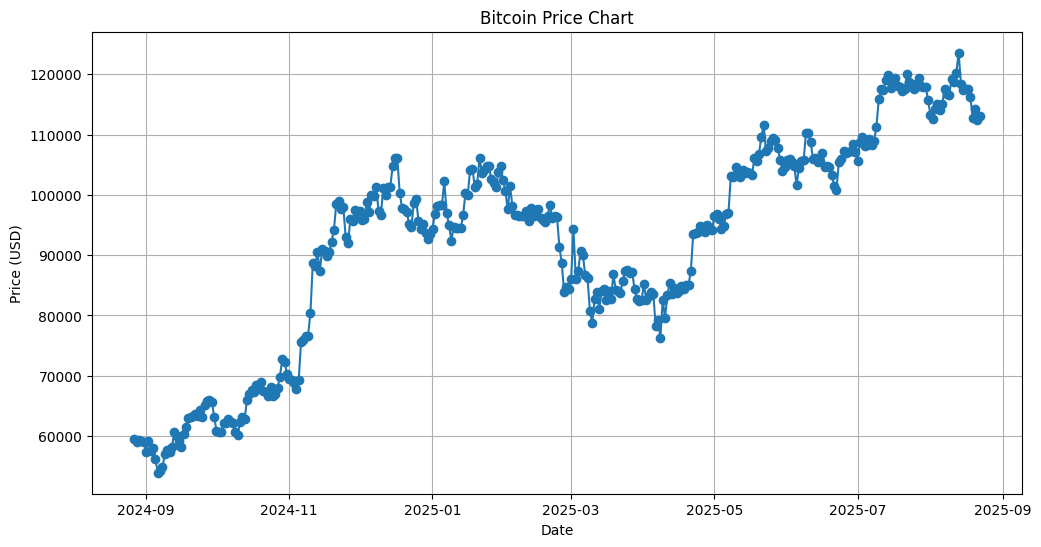

In [ ]:
# Display bitcoin price chart
get_coin_market_chart_as_df().plot()

In [ ]:
# Display bitcoin price table
get_coin_market_chart_as_df().reformat()

,price
date,
2025-08-22 01:17:39.820243,113006.506297
2025-08-21 01:17:39.820243,112414.399873
2025-08-20 01:17:39.820243,114252.397552
2025-08-19 01:17:39.820243,112778.344836
2025-08-18 01:17:39.820243,116256.412767
...,...
2024-08-31 01:17:39.820243,58960.236587
2024-08-30 01:17:39.820243,59156.246036
2024-08-29 01:17:39.820243,59351.579491
